In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import pretreat_data
import seaborn as sns
sns.set_style("darkgrid")
colors = sns.color_palette("colorblind6")

# Path to the data
train_path = "../data/ClimateTrain.csv"
test_path = "../data/ClimateTest.csv"

# Read as pandas dataframe and transform dates to datetime
train_df = pd.read_csv(train_path)
train_df['date'] = pd.to_datetime(train_df['date'])

test_df = pd.read_csv(test_path)
test_df['date'] = pd.to_datetime(test_df['date'])

# Plot description
train_df.describe()
test_df.describe()

,date,meantemp,humidity,wind_speed,meanpressure
count,114,114.000000,114.000000,114.000000,114.000000
mean,2017-02-26 12:00:00,21.713079,56.258362,8.143924,1004.035090
min,2017-01-01 00:00:00,11.000000,17.750000,1.387500,59.000000
25%,2017-01-29 06:00:00,16.437198,39.625000,5.563542,1007.437500
50%,2017-02-26 12:00:00,19.875000,57.750000,8.069444,1012.739316
75%,2017-03-26 18:00:00,27.705357,71.902778,10.068750,1016.739583
max,2017-04-24 00:00:00,34.500000,95.833333,19.314286,1022.809524
std,NaN,6.360072,19.068083,3.588049,89.474692


## Pretreat the data

In [7]:
train_df, test_df = pretreat_data(train_df, test_df)

Pre-treating data...


## Plot to double check that data looks okay

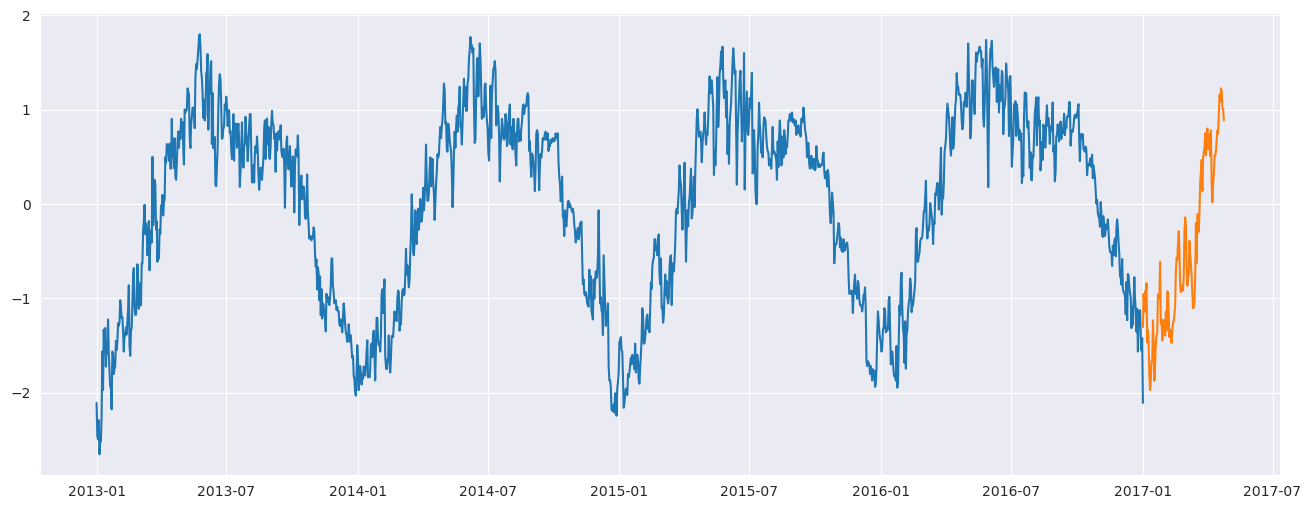

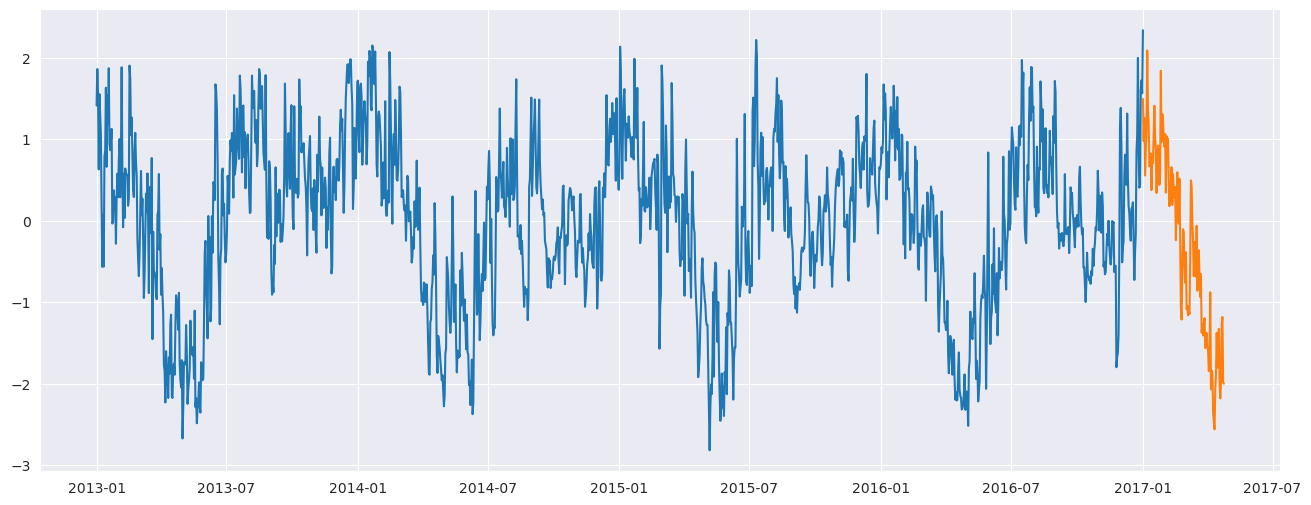

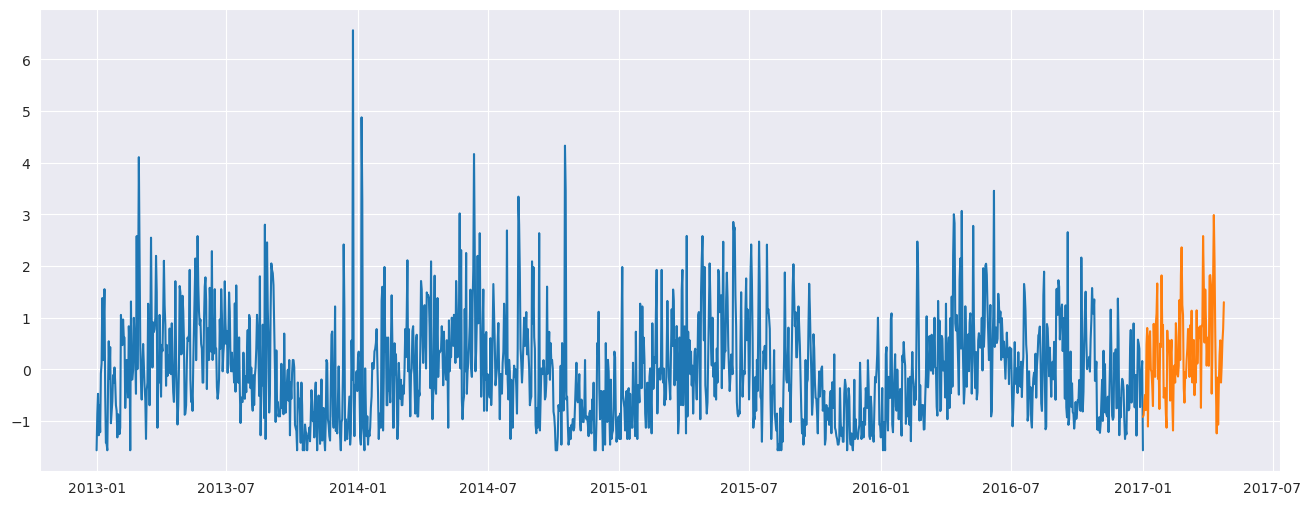

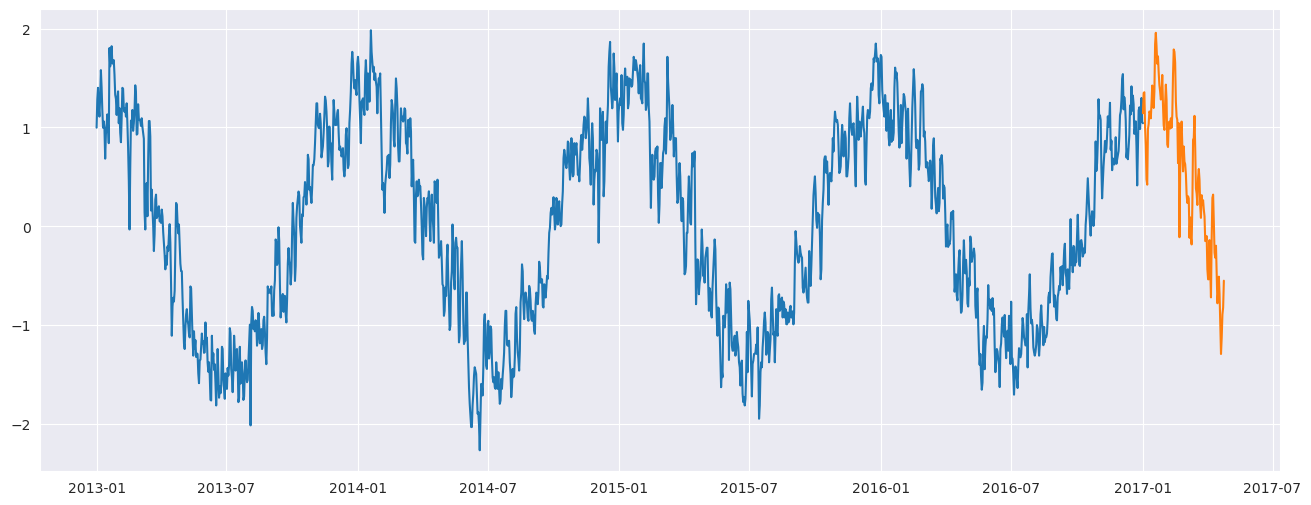

In [8]:
for col in train_df.columns[1:]:
    plt.figure(figsize=(16,6))
    plt.plot(train_df["date"], train_df[col])
    plt.plot(test_df["date"], test_df[col])
    

# 1.0 Initialize the model

In [ ]:
from utils import rolling_train_valid_split
from trainer import train, validate
from dataset import TimeSeriesDataset
from models import RNN_model, LSTM_model
from transformer_model import TransformerForecaster, DecoderForecaster
from torch import nn, optim
from torch.utils.data import DataLoader
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# number of points
window_size = 30
hidden_size = 128
embed_dim = 64
n_layers = 4
output_size = 1
input_size = 4 # How many features?

# Define model
# RNN
model = RNN_model(hidden_size=hidden_size, embed_dim = embed_dim, n_layers=n_layers, input_size=input_size, out_features=output_size, dropout_p=0.2)

# LSTM
model = LSTM_model(hidden_size=hidden_size, embed_dim = embed_dim, n_layers=n_layers, input_size=input_size, out_features=output_size, dropout_p=0.2)

# Full transformer
model = TransformerForecaster(hidden_size=hidden_size, embed_dim = embed_dim, 
                              encoder_heads=4, encoder_depth=2,
                              decoder_heads=4, decoder_depth=2, 
                              input_size=input_size, out_features=output_size, dropout_p=0.2)

# Decoder only
model = DecoderForecaster(hidden_size=hidden_size, embed_dim = embed_dim, 
                        decoder_heads=4, decoder_depth=2, 
                        input_size=input_size, out_features=output_size, dropout_p=0.2)

model = model.to(device)

# Define batch size
batch_size = 2048
n_epochs = 100
lr = 0.01

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr)

SyntaxError: expected argument value expression (2537981361.py, line 31)

## 1.1 Train

In [ ]:
# Generate rolling train-validation splits
loss_history = {0: {"train": [], "valid": []}, 
                1: {"train": [], "valid": []}, 
                2: {"train": [], "valid": []},
                3: {"train": []}}
for i, (train_data, valid_data) in enumerate(rolling_train_valid_split(train_df, months=6, window_size=window_size)):
    print("Training fold ", i)
    
    train_dataset = TimeSeriesDataset(df=train_data, window_size=window_size, horizon=1)
    if valid_data is not None:
        valid_dataset = TimeSeriesDataset(df=valid_data, window_size=window_size, horizon=1)
    
    # Initialize the dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    avg_val_loss = 0
    for epoch in range(n_epochs):
        avg_train_loss = train(model, train_loader, criterion, optimizer, device)
        
        loss_history[i]["train"].append(avg_train_loss)
        
        if valid_data is not None:
            avg_val_loss = validate(model, valid_loader, criterion, device)
            loss_history[i]["valid"].append(avg_val_loss)
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    

Training fold  0
Epoch 1/100, Train Loss: 1.2058, Val Loss: 23.3505
Epoch 2/100, Train Loss: 27.2874, Val Loss: 0.7266
Epoch 3/100, Train Loss: 0.9538, Val Loss: 2.8574
Epoch 4/100, Train Loss: 2.0261, Val Loss: 1.1920
Epoch 5/100, Train Loss: 0.6223, Val Loss: 1.4208
Epoch 6/100, Train Loss: 0.8856, Val Loss: 1.0281
Epoch 7/100, Train Loss: 0.7131, Val Loss: 1.0591
Epoch 8/100, Train Loss: 0.6391, Val Loss: 1.0021
Epoch 9/100, Train Loss: 0.5162, Val Loss: 1.0327
Epoch 10/100, Train Loss: 0.4500, Val Loss: 1.0560
Epoch 11/100, Train Loss: 0.4451, Val Loss: 0.9406
Epoch 12/100, Train Loss: 0.4173, Val Loss: 0.8054
Epoch 13/100, Train Loss: 0.4032, Val Loss: 0.7117
Epoch 14/100, Train Loss: 0.3906, Val Loss: 0.6546
Epoch 15/100, Train Loss: 0.3728, Val Loss: 0.7244
Epoch 16/100, Train Loss: 0.3757, Val Loss: 0.7421
Epoch 17/100, Train Loss: 0.3498, Val Loss: 0.7126
Epoch 18/100, Train Loss: 0.3393, Val Loss: 0.6866
Epoch 19/100, Train Loss: 0.3080, Val Loss: 0.6591
Epoch 20/100, Train L

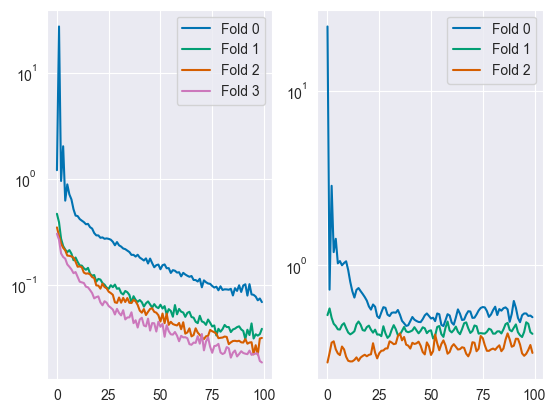

In [ ]:
fig, ax = plt.subplots(1,2)
for i in range(4):
    ax[0].plot(loss_history[i]["train"], label=f"Fold {i}", color=colors[i])
    ax[0].legend()
    if "valid" in loss_history[i]:
        ax[1].plot(loss_history[i]["valid"], label=f"Fold {i}", color=colors[i])
        ax[1].legend()
    ax[0].semilogy()
    ax[1].semilogy()

## 1.2 Test

In [ ]:
# Add The required windows size to the test df so that we can start predicting from the beginning
test_start_date = test_df["date"].loc[0]
test_window_date = test_start_date - pd.Timedelta(days=window_size)
filtered_train_df = train_df[(train_df['date'] >= test_window_date) & (train_df['date'] < test_start_date)]
test_df_altered = pd.concat([filtered_train_df, test_df], ignore_index=True)
test_df_altered


,date,meantemp,humidity,wind_speed,meanpressure
0,2016-12-02,-0.855620,0.900821,-0.398152,1.277458
1,2016-12-03,-0.583441,-0.511168,-0.181091,1.490064
2,2016-12-04,-0.897581,-0.327535,-0.228235,1.539300
3,2016-12-05,-0.933460,-0.247675,-0.396608,1.182854
4,2016-12-06,-0.946783,0.546345,-0.973783,1.305863
...,...,...,...,...,...
139,2017-04-20,1.225416,-1.980232,-0.252790,-1.290600
140,2017-04-21,1.191393,-1.272997,0.077222,-1.122753
141,2017-04-22,1.007672,-1.182173,0.531577,-0.891125
142,2017-04-23,1.004270,-1.980232,0.784389,-0.820629


In [ ]:
test_dataset = TimeSeriesDataset(df=test_df_altered, window_size=window_size, horizon=1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


model.eval()
total_test_loss = 0
results = {"pred": [], "gt": []}
with torch.no_grad(): # Iterate
    for batch in test_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Initialize the hidden state
        prev_state = model.init_state(inputs.size(0), device)
        
        # Pass the input through the model
        outputs, _ = model(inputs, prev_state)
        loss = torch.sqrt(criterion(outputs, targets))
        
        # Calculate loss
        total_test_loss += loss.item()

        results["gt"].append(targets.cpu())
        results["pred"].append(outputs.cpu())
    
# Return average validation loss
avg_test_loss = total_test_loss / len(test_loader)
print(avg_test_loss)
gt = torch.cat(results["gt"]).numpy()
pred = torch.cat(results["pred"]).numpy()

0.5354264378547668


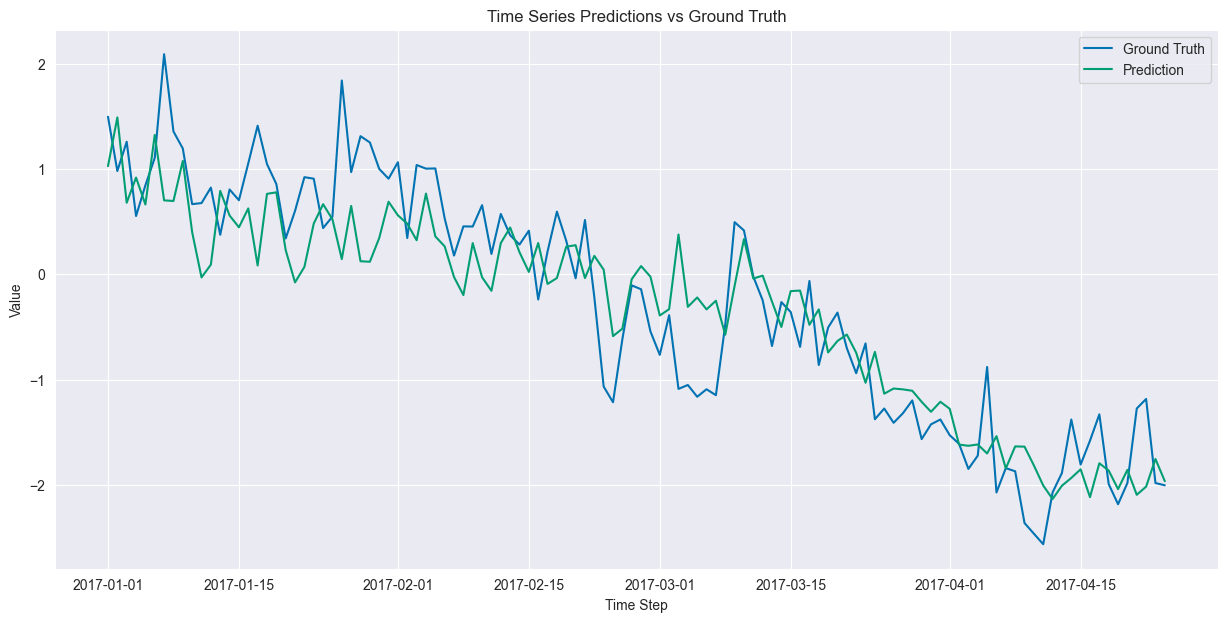

In [ ]:

# Plot the ground truth and predictions
plt.figure(figsize=(15, 7))
plt.plot(test_df["date"], gt, label="Ground Truth", color=colors[0])
plt.plot(test_df["date"], pred, label="Prediction", color=colors[1])

# Add labels, legend, and grid
plt.title("Time Series Predictions vs Ground Truth")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid("on")

plt.show()

# plt.plot(results["gt"])
# plt.plot(results["pred"])